# 08-02. Voting Ensemble
##### *단일 모델을 앙상블하여 더 나은 예측을 하는 앙상블 모델 만들기*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

from sklearn.neighbors import KNeighborsClassifier    # 랜덤포레스트
from sklearn.tree import DecisionTreeClassifier       # 의사결정트리
from sklearn.svm import SVC                           # 서포트벡터머신
from sklearn.ensemble import VotingClassifier         # 배깅

from sklearn.model_selection import train_test_split  # 데이터분할
from sklearn.metrics import accuracy_score            # 정확도 확인 

<hr>

## 01. 데이터셋 가져오기

In [2]:
mnist = datasets.load_digits()
features, labels = mnist.data, mnist.target

print('DV :\n', features)
print('\nIV :', labels)

DV :
 [[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]

IV : [0 1 2 ... 8 9 8]


In [3]:
# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2) # 8:2
print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)

X_train size: (1437, 64)
X_test size: (360, 64)
y_train size: (1437,)
y_test size: (360,)


<hr>

## 02. 단일 모델 정확도 측정
##### *의사결정트리, KNN, SVM 모델의 정확도를 측정*

In [4]:
# 1) 의사결정트리
dtree = DecisionTreeClassifier(criterion='gini',    # 지니계수를 이용한 객체 생성
                               max_depth=8,         # overfitting을 줄이기 위한 매개변수 설정
                               max_features=32,
                               random_state=35).fit(X_train, y_train)

# test 데이터에 대한 예측값을 변수에 저장
dtree_predict = dtree.predict(X_test)

In [5]:
# 2) KNN
knn = KNeighborsClassifier(n_neighbors=299,   # 최적의 k값 (찾는거 생략하고 바로 매개변수로 넣음)
                           ).fit(X_train, y_train) 

# test 데이터에 대한 예측값을 변수에 저장
knn_predict = knn.predict(X_test)

In [6]:
# 3) SVM (C=0.1, gamma=0.003 >> 최적의 매개변수, GridSearchCV 과정 생략)
svm = SVC(C=0.1, gamma=0.003,
          probability=True,       # 확률을 예측할 수 있는 모델 생성. predict_proba() 메서드를 실행하기 위함.
          random_state=35).fit(X_train, y_train)

# svm_predict_proba = svm.predict_proba(X_test) 
# 각 클래스에 속한 확률값으로 반환 >> 회귀모델에는 사용할 수 없고, 분류모델에서 활용됨

svm_predict = svm.predict(X_test)

In [7]:
print(f"""[accuracy]\n
의사결정트리: {round(accuracy_score(y_test, dtree_predict), 3)},
         KNN: {round(accuracy_score(y_test, knn_predict), 3)},
         SVM: {round(accuracy_score(y_test, svm_predict), 3)}      
""")

[accuracy]

의사결정트리: 0.831,
         KNN: 0.861,
         SVM: 0.925      



##### *소프트 보팅 또는 하드 보팅은 sklearn의 voting classifier를 사용하여 쉽게 구현 가능*

In [8]:
# predict_proba(): 확률의 값으로 계산한 결과를 반환하는 메서드
svm_proba = svm.predict_proba(X_test)

# 2개의 값만 우선 확인
svm_proba[:2]

# 다른 모델들도 `predict_proba()` 함수로 확률값을 확인할 수 있음

array([[0.00301521, 0.01539632, 0.83798147, 0.00697977, 0.00718525,
        0.01099738, 0.00365586, 0.00708201, 0.09394806, 0.01375866],
       [0.0037367 , 0.01118552, 0.00764305, 0.00475032, 0.9008824 ,
        0.01114448, 0.00428801, 0.00851048, 0.03832171, 0.00953733]])

<hr>

## 03. 하드 보팅
##### *하드 보팅은 일반적인 투표와 같이 각 분류기의 예측값들을 모아, 가장 많은 득표를 받은 예측값으로 최종 결론을 내는 방식*

In [9]:
voting_clf  = VotingClassifier(estimators=[('knn', knn),    # (모델 이름, 해당 모델의 변수명) 
                                           ('svm', svm),
                                           ('decisionTree', dtree)],
                               weights=[1, 1, 1],           # 가중치는 모두 동일하게 설정 (하드보팅에서는 가중치의 의미가 없음, 득표수로 계산하기 때문)
                               voting='hard'                # 하드보팅 설정
                              ).fit(X_train, y_train)

hard_predict = voting_clf.predict(X_test)

In [10]:
accuracy_score(y_test, hard_predict)

0.9333333333333333

<hr>

## 04. 소프트 보팅
##### *모든 분류값의 확률을 더해 최대 점수를 가진 분류값을 결론으로 도출*

In [11]:
voting_clf  = VotingClassifier(estimators=[('knn', knn),    # (모델 이름, 해당 모델의 변수명) 
                                           ('svm', svm),
                                           ('decisionTree', dtree)],
                               weights=[1, 1, 1],
                               voting='soft'                # 소프트 설정
                              ).fit(X_train, y_train)

soft_predict = voting_clf.predict(X_test)

In [12]:
accuracy_score(y_test, soft_predict)

0.9083333333333333

<hr>

## 05. 정확도 비교 시각화

([<matplotlib.axis.XTick at 0x1e4997c1fd0>,
 [Text(0, 0, 'decision tree'),
  Text(1, 0, 'KNN'),
  Text(2, 0, 'SVM'),
  Text(3, 0, 'hard voting'),
  Text(4, 0, 'soft voting')])

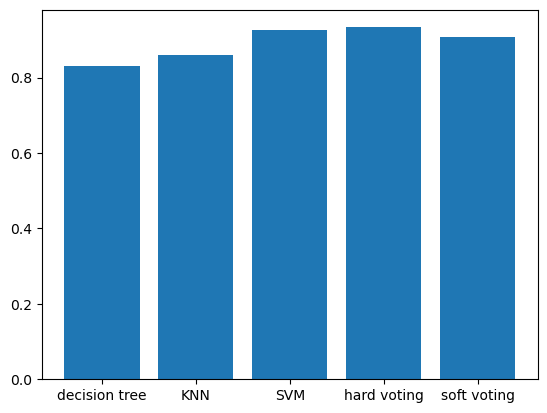

In [13]:
x = np.arange(5)
plt.bar (x, height= [accuracy_score(y_test, dtree_predict),
                     accuracy_score (y_test, knn_predict),
                     accuracy_score (y_test, svm_predict),
                     accuracy_score (y_test, hard_predict),
                     accuracy_score (y_test, soft_predict) ]
        )

plt.xticks(x, ['decision tree', 'KNN', 'SVM', 'hard voting', 'soft voting'])